Looking into learning functions, let's visualize a really simple function -- where we just keep the values along a matrix diagonal stripe. We'll set up a bunch of random matrixes, and map those through just the diagonals of those matrixes.

In order to see inside the learning process, and what the different learning functions actually do -- we'll inspect what is being learned with some animation. If all works out well, we'll 'learn' a diagonal mapping function!

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


This is our objective function -- we know what we are looking for, and much like solving an equation in good old algebra, we'll be using machine learning to figure out the answer. We'll take a look at it as an image.

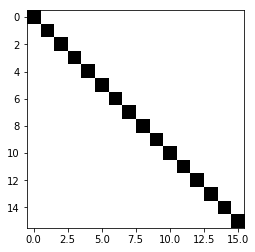

In [2]:
size = 16
batch_size = 32
objective = nd.ones(size).diag()
plt.imshow(objective.asnumpy(), cmap='binary')

Now - a set of random inputs and outputs, including a data loader to dispense mini batches.

In [3]:
inputs = [nd.random.uniform(shape=(size, size)) for i in range(1024)]
outputs = [input * objective for input in inputs]
dataset = mx.gluon.data.dataset.ArrayDataset(inputs, outputs)
data_loader = mx.gluon.data.DataLoader(dataset, batch_size=batch_size)

Ok -- now let's look at what we've created -- some 'white noise' and then a nice extraction along the diagonal of that noise by multiplying the matrix.

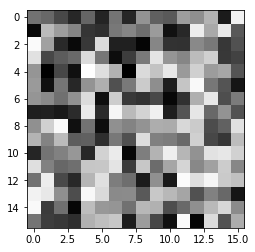

In [4]:
plt.imshow(inputs[0].asnumpy(), cmap='binary')

And the output -- multiply that random input by our diagonal stripe -- and only the diagonal values from the random noise above remain. Notice it isn't all black pixels, but greys!

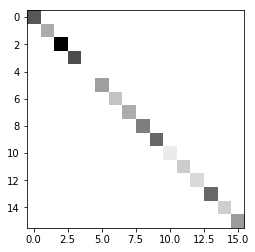

In [5]:
plt.imshow(outputs[0].asnumpy(), cmap='binary')

OK -- now we'll set up to learn, starting with a random matrix. This is again white noise, and we'll be using machine learning to adjust the values to get to our nice solid diagonal stripe objective function.

We're setting up an MxNet parameter, not just an array, as we'll be using an optmizer to adjust these values -- machine learning!

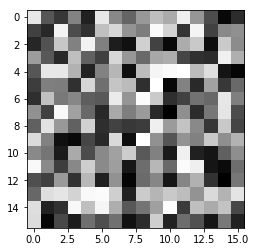

In [6]:
#everything will be run on the CPU context, these are really simple models
ctx = mx.cpu()

params = gluon.parameter.ParameterDict('_')
learned_diagonal = params.get('learned_diagonal', grad_req='write', shape=(size, size))
params.initialize(ctx=ctx)
plt.imshow(learned_diagonal.data().asnumpy(), cmap='binary')

This is a really simple network - a single multiplication, with a square loss function. At each training epoch, we'll capture the value of the learned objective as a numpy array so we can take a look.

In [7]:
def net(input):
    return input * learned_diagonal.data()

def learn(net, optimizer):
    params.initialize(ctx=ctx, force_reinit=True)
    epochs = 10
    #initial value, so we can see where we started
    learning_steps = []
    learning_steps.append(learned_diagonal.data().asnumpy())
    #simple loss function
    square_loss = gluon.loss.L2Loss()
    losses = []
    for e in range(epochs):
        for input_batch, output_batch in dataset:
            with autograd.record():
                predicted = net(input_batch)
                loss = square_loss(predicted, output_batch)
                loss.backward()
            optimizer.step(input_batch.shape[0])
        learning_steps.append(learned_diagonal.data().asnumpy())

        print("Loss: {0}".format(nd.sum(loss).asscalar()), flush=True)
        losses.append(nd.sum(loss).asscalar())
    return learning_steps, losses
    

And here is a function to make an animated bitmap of the learning. At each step, we are simply showing an image, and then joining it together with the `FuncAnimation` class.

In [8]:
def animate(frames):
    fig, ax = plt.subplots(figsize=(4, 4))

    def update(i):
        ax.imshow(frames[i], cmap='binary')
        ax.set_axis_off()

    anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=200)
    plt.close()
    return HTML(anim.to_jshtml())

And now -- we can see -- the diagonal is emerging -- but there is still a lot of noise. 

In [9]:
optimizer = gluon.Trainer(params, 'sgd', {'learning_rate': 0.001})
steps, _ = learn(net, optimizer)
animate(steps)

Loss: 0.16884537041187286
Loss: 0.16839829087257385
Loss: 0.16795241832733154
Loss: 0.16750770807266235
Loss: 0.16706417500972748
Loss: 0.1666218340396881
Loss: 0.16618067026138306
Loss: 0.16574065387248993
Loss: 0.16530181467533112
Loss: 0.16486412286758423


Basically -- we didn't go far enough. SO we have a couple options with plain stochastic gradient descent -- we can:
* learn more -- more data, more epochs
* learn faster -- a higher learning rate

We already know that more data helps learning, let's look at the effect of a faster learning rate.

In [10]:
optimizer = gluon.Trainer(params, 'sgd', {'learning_rate': 0.1})
learning_steps, losses = learn(net, optimizer)
animate(learning_steps)

Loss: 0.12338604778051376
Loss: 0.09465217590332031
Loss: 0.07261284440755844
Loss: 0.055707670748233795
Loss: 0.04274001717567444
Loss: 0.03279237821698189
Loss: 0.02516108937561512
Loss: 0.019306505098938942
Loss: 0.014814808964729309
Loss: 0.011368612758815289


You can see right away the lower loss values -- and in the animation, a more clear diagonal emerges. Now -- this isn't a general answer to simply increase the learning rate, learning rate is what we call a *hyperparameter*, and you'll need to tune it in context of our problem.

In addition to the learning rate, there is another parameter -- momentum.

In [11]:
optimizer = gluon.Trainer(params, 'sgd', {'learning_rate': 0.01, 'momentum': 0.1})
learning_steps, losses = learn(net, optimizer)
animate(learning_steps)

Loss: 0.15809780359268188
Loss: 0.15350405871868134
Loss: 0.14904385805130005
Loss: 0.14471334218978882
Loss: 0.1405087113380432
Loss: 0.13642634451389313
Loss: 0.13246263563632965
Loss: 0.128614142537117
Loss: 0.12487754970788956
Loss: 0.12124957144260406


OK -- same data -- same number of epochs -- much much lower losses. Momentum -- speeds up learning -- the higher the momentum, ranged from `0.0` to `1.0` the faster the learning accelerates. Let's try a larger value.

In [12]:
optimizer = gluon.Trainer(params, 'sgd', {'learning_rate': 0.01, 'momentum': 0.9})
learning_steps, losses = learn(net, optimizer)
animate(learning_steps)

Loss: 0.12570486962795258
Loss: 0.09639302641153336
Loss: 0.07391907274723053
Loss: 0.05668716877698898
Loss: 0.04347408562898636
Loss: 0.03334212675690651
Loss: 0.025572476908564568
Loss: 0.019614161923527718
Loss: 0.015044733881950378
Loss: 0.011540261097252369


You can instantly see smaller losses, and the image resulting is nearly a perfect diagonal in just ten epochs. *Momentum* is another *hyperparameter* you can tune on stochastic gradient descent. But -- there are multiple other learning algorithms with different parameters available.